In [1]:
import re
import pandas                    as pd
import matplotlib.pyplot         as plt
import numpy                     as np
import statsmodels.api           as sm
import seaborn                   as sns

from joblib                      import Parallel, delayed

from statsmodels.formula.api     import rlm
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook               import tqdm 


# robust regression for spatial associations
def run_glm(gene_df, measure='mean_degree'):

    # all data
    lm = rlm(f"expression ~ {measure} + C(timepoint)", data = gene_df).fit() # robust regression

    degree_c = lm.params[f'{measure}']
    degree_logp = -np.log(lm.pvalues[f'{measure}'])
    
    age_c = lm.params['C(timepoint)[T.mid]']
    age_logp = -np.log(lm.pvalues['C(timepoint)[T.mid]'])

    genename = gene_df['gene'].iloc[0]
    
    return [genename, degree_c, degree_logp, age_c, age_logp] 



# manhattan plot function
def manhattan_plot(df, ax, palette, data_col = 'degree_C', p_col = 'degree_logp'):
    
    pal_dict = dict(zip(df['tissue'].unique(), palette))

    # plot results for each gene in each zone
    # positive association
    sns.scatterplot(x='index', y=p_col, hue='tissue', data=df[df[data_col]>0], legend=False,
                    s=1, alpha=0.5, edgecolor='grey', ax=ax[0], palette=palette)
    # negative association
    sns.scatterplot(x='index', y=df[df[data_col]<0][p_col]*-1, hue='tissue', data=df[df[data_col]<0], legend=False,
                    s=1, alpha=0.5, edgecolor='grey', ax=ax[1], palette=palette)
    
    # identify any that pass fdr correction
    fdr01 = df[fdrcorrection(np.exp(-df[p_col]), 0.01)[0]]
    fdr05 = df[fdrcorrection(np.exp(-df[p_col]), 0.05)[0]]

    # plot onto same axis
    # positive
    sns.scatterplot(x='index', y=p_col, hue='tissue', data=fdr05[fdr05[data_col]>0], legend=False,
                    s=16, alpha=0.9, edgecolor='grey', ax=ax[0], palette=[pal_dict[t] for t in fdr05[fdr05[data_col]>0]['tissue'].unique()])
    sns.scatterplot(x='index', y=p_col, hue='tissue', data=fdr01[fdr01[data_col]>0], legend=False,
                    s=25, alpha=0.9, edgecolor='black', ax=ax[0], palette=[pal_dict[t] for t in fdr01[fdr01[data_col]>0]['tissue'].unique()])
    # negative
    sns.scatterplot(x='index', y=fdr05[fdr05[data_col]<0][p_col]*-1, hue='tissue', data=fdr05[fdr05[data_col]<0], legend=False,
                    s=16, alpha=0.9, edgecolor='grey', ax=ax[1], palette=[pal_dict[t] for t in fdr05[fdr05[data_col]<0]['tissue'].unique()])
    sns.scatterplot(x='index', y=fdr01[fdr01[data_col]<0][p_col]*-1, hue='tissue', data=fdr01[fdr01[data_col]<0], legend=False,
                    s=25, alpha=0.9, edgecolor='black', ax=ax[1], palette=[pal_dict[t] for t in fdr01[fdr01[data_col]<0]['tissue'].unique()])

    
    # fdr labels
    ax[0].axhline(fdr01[p_col].min(), xmin=0., xmax=1, lw=.5, color='black', zorder=0)
    ax[0].axhline(fdr05[p_col].min(), lw=.5, color='grey', zorder=0)
    ax[1].axhline(-fdr01[p_col].min(), xmin=0., xmax=1, lw=.5, color='black', zorder=0)
    ax[1].axhline(-fdr05[p_col].min(), lw=.5, color='grey', zorder=0)
    
    ax[0].text(len(df)*1.01,fdr01[p_col].min()*.95, r'$p_{FDR} = 0.01$')
    ax[0].text(len(df)*1.01,fdr05[p_col].min()*.95, r'$p_{FDR} = 0.05$', color='grey')
    ax[1].text(len(df)*1.01,-fdr01[p_col].min()*1.05, r'$p_{FDR} = 0.01$')
    ax[1].text(len(df)*1.01,-fdr05[p_col].min()*1.05, r'$p_{FDR} = 0.05$', color='grey')
    
    # axis labels
    for a in ax:
        a.set_xlim(0, len(df))
        for i in np.arange(0,5):
            #a.axvline((len(df)//5) * i, ymin=0, ymax=30, zorder=0, color=palette[i], lw=0.5, alpha=.5)
            a.fill_betweenx((-30,30), x1=(len(df)//5) * i, x2=(len(df)//5) * (i+1), zorder=0, alpha=.065, color=palette[i])

        # ax labels
        a.set_xticks(np.linspace(len(df)/10, len(df)-len(df)/10, 5))
        a.set_xticklabels(['cortical plate', 'subplate', 'intermediate', 'subventricular', 'ventricular'])
        a.set_xlabel(' ')
        a.set_ylabel('-log(p)', fontsize=12)
        a.tick_params('x',length=0, labelsize=15)
        a.tick_params('y',length=0,  labelsize=12)

    ax[0].set_yticks([0,5,10,15,20])
    ax[0].set_ylim([0,22])
    
    ax[1].set_ylim([-22,0])
    ax[1].set_yticks([0, -5, -10, -15, -20])
    
    labels = [item.get_text() for item in ax[1].get_yticklabels()]
    flipped_labels = [str(-int(re.sub(r'[^\x00-\x7F]+','-', l))) for l in labels]
    ax[1].set_yticklabels(flipped_labels)
    ax[1].set_xticklabels('')
    
    return fdr05, fdr01

In [2]:
# set parameters
microarray_path = 'MicroarrayData/' # contains processed microarray data
hub_path = 'NetworkData/'           # contains nodal metrics
measure = 'mean_degree'             # measure to use to define hubs
subdiv = '90'                       # uBrain parcellation resolution
missingness = 0.1                   # proportion of missing data to remove samples 

In [3]:
# load preprocessed microarray data (after probe selection etc)
data = pd.read_csv(f'{microarray_path}microarray-data.csv') # download from uBrain resource

# identify genes with missing data in >n% of samples
data_pivot = data.pivot_table(values='expression', index=['gene'] , columns=['cortical_region', 'tissue', 'specimen_id']).T
data_pivot = data_pivot.reset_index()
nan_genes = (pd.isna(data_pivot).sum(0) / len(data_pivot)) < missingness

print('removing {:} genes with >{:}% missing samples'.format(len(nan_genes)-sum(nan_genes), missingness*100))
print('{:} genes remaining'.format(sum(nan_genes) - 3)) #-3 to account for region, tissue and id columns
print('')

data_pivot = data_pivot.loc[:,nan_genes]
keep_genes = list(data_pivot.drop(['cortical_region', 'tissue', 'specimen_id'], axis=1).columns)

# save list of all genes for gene enrichment analysis
np.savetxt('OUTPUTS/all-genes.txt', keep_genes, fmt='%s')

# drop genes missing data
data = data[data['gene'].isin(keep_genes)]

# load network hub data
left_hub_data = pd.read_excel(f'{hub_path}/ubrain_subdiv{subdiv}_hubness_left.xlsx')
left_hub_data = left_hub_data.rename({measure:'left_mean_value'}, axis='columns')

right_hub_data = pd.read_excel(f'{hub_path}/ubrain_subdiv{subdiv}_hubness_right.xlsx')
right_hub_data = right_hub_data.rename({measure:'right_mean_value'}, axis='columns')

# average degree across hemispheres
all_hubs = pd.merge(left_hub_data, right_hub_data, on='Region')
mean_hubness = (all_hubs['left_mean_value'] + all_hubs['right_mean_value']) / 2
all_hubs.insert(1, measure,  mean_hubness)

# dictionaries for data
hubness_dict = dict(zip(all_hubs['Region'], all_hubs[measure]))

# add hub metric to data 
data[f'{measure}'] = data['cortical_region'].map(hubness_dict)

# save out
data.to_csv(f'{microarray_path}microarray-data-for-hub-analysis-clean-{measure}-subdiv{subdiv}.csv')

removing 2271 genes with >10.0% missing samples
7457 genes remaining



In [4]:
all_results = []
# run in each tissue compartment independently
for t in tqdm(sorted(data['tissue'].unique())):
    # get data frame for tissue
    subdf = data[(data['tissue']==t)]
    
    # run in parallel for each gene
    results = Parallel(n_jobs=-1)(  
                                    delayed(run_glm)(group, measure=measure)
                                    for _, group in tqdm(subdf.groupby('gene'))
                                    )
    
    results = pd.DataFrame(results)
    results.columns = ['gene', 
                       'degree_C',  'degree_logp',  
                       'age_C', 'age_logp'] 

    results.insert(0, 'tissue', t)

    all_results.append(results)

all_results = pd.concat(all_results).reset_index(drop=True).reset_index()
all_results.to_csv(f'OUTPUTS/all_results_{measure}_subdiv{subdiv}.csv', index=None)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7457 [00:00<?, ?it/s]

  0%|          | 0/7457 [00:00<?, ?it/s]

  0%|          | 0/7457 [00:00<?, ?it/s]

  0%|          | 0/7457 [00:00<?, ?it/s]

  0%|          | 0/7457 [00:00<?, ?it/s]

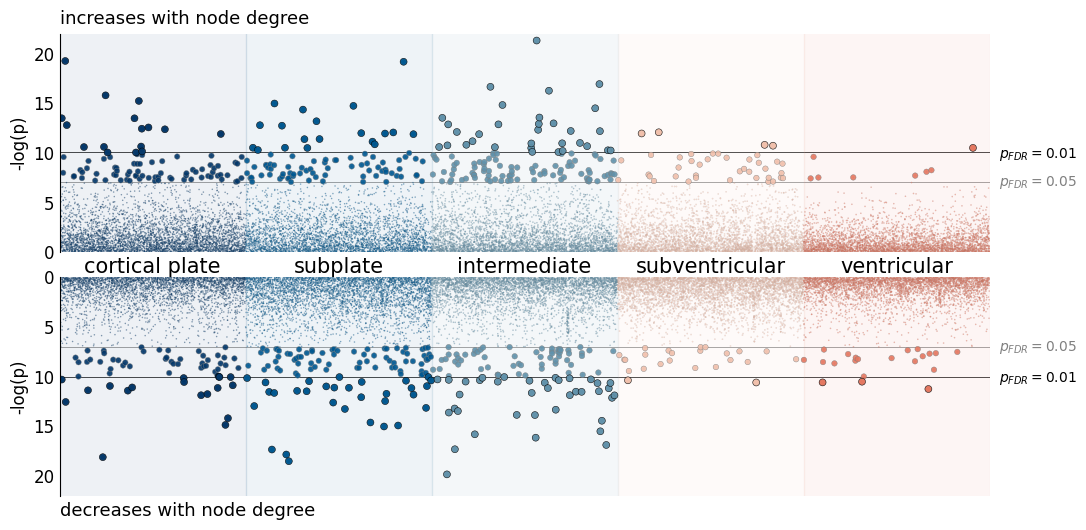

In [5]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,6), sharey=False)
palette = ['#033769', '#005891', '#6192ab', '#f1c0ac', '#e57760']
data_col = 'degree_C'
fdr05, fdr01 = manhattan_plot(all_results, (ax1, ax2), palette, p_col = 'degree_logp', data_col = data_col)
sns.despine(bottom=True, left=False)
plt.subplots_adjust(hspace=0.115)
ax1.text(0, 23, 'increases with node degree', fontsize=13)
ax2.text(0, -24, 'decreases with node degree', fontsize=13)

# save plot
plt.savefig(f'OUTPUTS/gene-associations-{measure}_subdiv{subdiv}.png', transparent=False, facecolor='white', dpi=300)

# save associations that survive FDR correction
fdr05.to_csv(f'OUTPUTS/significant-associations-{data_col}-fdr05-{measure}_subdiv{subdiv}.csv', index=None)
fdr01.to_csv(f'OUTPUTS/significant-associations-{data_col}-fdr01-{measure}_subdiv{subdiv}.csv', index=None)

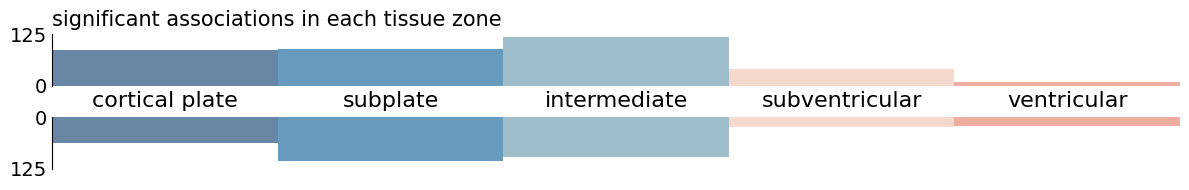

In [6]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,2), sharex=False)
palette = ['#033769', '#005891', '#6192ab', '#f1c0ac', '#e57760']

ax1.bar(x=['cortical plate', 'subplate', 'intermediate', 'subventricular', 'ventricular'], 
        height=[len(fdr05[(fdr05['degree_C']>0) & (fdr05['tissue'].str.contains(a))]) for a in ['0.cortical_plate', '1.subplate', '2.intermediate', '3.subventricular', '4.ventricular']],
        color=palette, width=1, alpha=0.6)
ax2.bar(x=['cortical plate', 'subplate', 'intermediate', 'subventricular', 'ventricular'], 
        height=[-len(fdr05[(fdr05['degree_C']<0) & (fdr05['tissue'].str.contains(a))]) for a in ['0.cortical_plate', '1.subplate', '2.intermediate', '3.subventricular', '4.ventricular']],
        color=palette, width=1, alpha=0.6)
ax1.set_yticks((0,125), labels=['0','125'])
ax2.set_yticks((0,-125), labels=['0','125'])
ax2.set_xticklabels('')

for a in (ax1, ax2):
    a.set_xlim(-0.5,4.5)
    a.tick_params(length=0)
    a.tick_params('y', labelsize=14)
    a.tick_params('x', labelsize=16)
    
ax1.set_title('significant associations in each tissue zone', loc='left', fontsize=15)
sns.despine(bottom=True)
plt.tight_layout()
plt.subplots_adjust(hspace=0.615)
plt.savefig(f'OUTPUTS/significant-associations-per-zone-{measure}_subdiv{subdiv}.png', dpi=300, transparent=False, facecolor='white')